# Imports -> Data Loading -> Handling Class Imbalance :

In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import helpers
import model_helpers

In [2]:
np.random.seed(40)

In [3]:
data = pd.read_csv("../data/body_level_classification_train.csv")
x = data.drop('Body_Level', axis=1)
y = data['Body_Level']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=31) #31

class_column = 'Body_Level'
class_labels = ['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4']
class_colors = ['blue','orange', 'green', 'red']
numeric_columns = x_train.select_dtypes(include=[float, int]).columns
categorical_columns = [x for x in x_train.columns if x not in numeric_columns]

print("Training set size:", len(x_train))
print("Testing set size:", len(x_test))


Training set size: 1033
Testing set size: 444


In [4]:
x_train_sampled, y_train_sampled = helpers.class_balance(x_train, y_train, oversampling_only=True)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ddc68aa60>
Traceback (most recent call last):
  File "/home/makrion/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/makrion/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/makrion/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/makrion/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>

# Evaluating Models

### I will go on with those classifiers:
    1. logistic Regression.
    2. adaboost.
    3. SVM.
    4. random forrest

##### helpers

In [53]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

##### logistic Regression:

- testing different values for the solver parameters :
    - C : Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

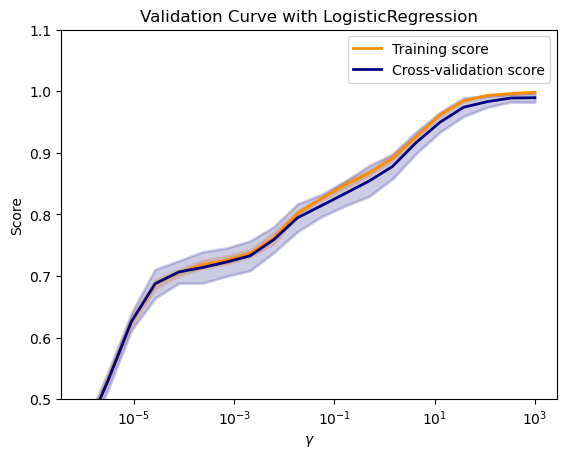

In [28]:
param_range=np.logspace(-6,3, 20)
#param_range=np.linspace(-7,20,10)
test_scores_mean, train_scores_mean = model_helpers.draw_validation_curve(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          LogisticRegression(max_iter=1000000),
                                                                          n_jobs=5,
                                                                          param_range=param_range,
                                                                          param_name='C',
                                                                          y_lim= 0.5)

In [29]:
best_param_index = np.argmax(test_scores_mean)
best_param_value = param_range[best_param_index]
print("Best Regularization Parameter:", best_param_value)
print("Best Mean Test Score:", test_scores_mean[best_param_index], train_scores_mean[best_param_index])


Best Regularization Parameter: 1000.0
Best Mean Test Score: 0.9893291209085472 0.9980049614801599


In [59]:
# Create a logistic regression classifier
# solver: Literal['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] = "lbfgs"
# penalty: Literal['l1', 'l2', 'elasticnet']
logisticregression_classifier = LogisticRegression(max_iter=1000000, C=1000)
print("logistic regression classifier results:\n")
logisticregression_classifier, doc = helpers.test_model(logisticregression_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

logistic regression classifier results:

     out of sample ( predict(test) ):
         accuracy: 96.62162162162163
         weighted F1 score: 96.56955903271692

     in sample ( predict(train) ):
         accuracy: 99.7340425531915
         weighted F1 score: 99.73404134728855


- learning curve

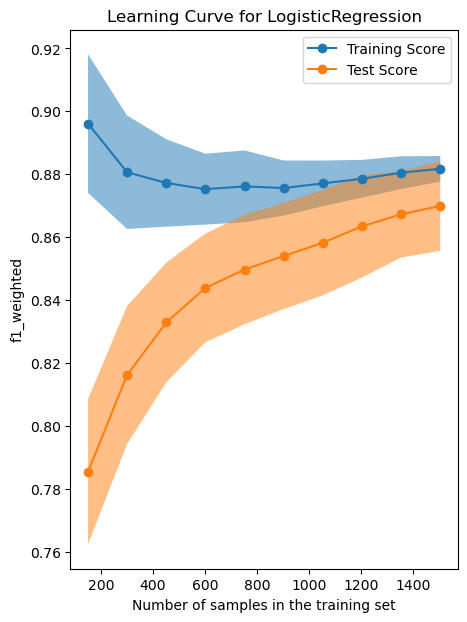

In [33]:
model_helpers.draw_learning_curve(x_train_sampled, y_train_sampled, LogisticRegression(max_iter=1000000), n_jobs=4, cv_n_splits=50)

- scalability curve

[[0.0056262  0.00543332 0.0052166  0.00530934 0.00526762 0.00569582
  0.00523543 0.00537872 0.00546455 0.00538182 0.00540709 0.00642991
  0.00538826 0.00548768 0.00532556 0.00572562 0.00536466 0.00542569
  0.00530791 0.00524616 0.00537038 0.00540233 0.00546837 0.00533414
  0.00541282 0.00537896 0.00518894 0.00533891 0.0072093  0.00520372
  0.00534964 0.00571918 0.00572777 0.00525832 0.00527596 0.00528622
  0.00525904 0.00570154 0.00572062 0.00526476 0.00524855 0.00571656
  0.00536489 0.00521135 0.00587893 0.00572133 0.00691247 0.0058856
  0.00526977 0.00534654]
 [0.00662017 0.0053966  0.00533342 0.00621009 0.00543213 0.00531769
  0.0053072  0.00542974 0.00542784 0.00584698 0.00530243 0.00565934
  0.00531983 0.00575066 0.00529337 0.00535917 0.00859928 0.00536752
  0.00536346 0.00541353 0.00519109 0.00551224 0.00521779 0.00529337
  0.00569844 0.00530434 0.00542307 0.0052793  0.00567245 0.00529027
  0.00537968 0.00555825 0.00524735 0.00531435 0.00571752 0.00533271
  0.0057478  0.00542831 

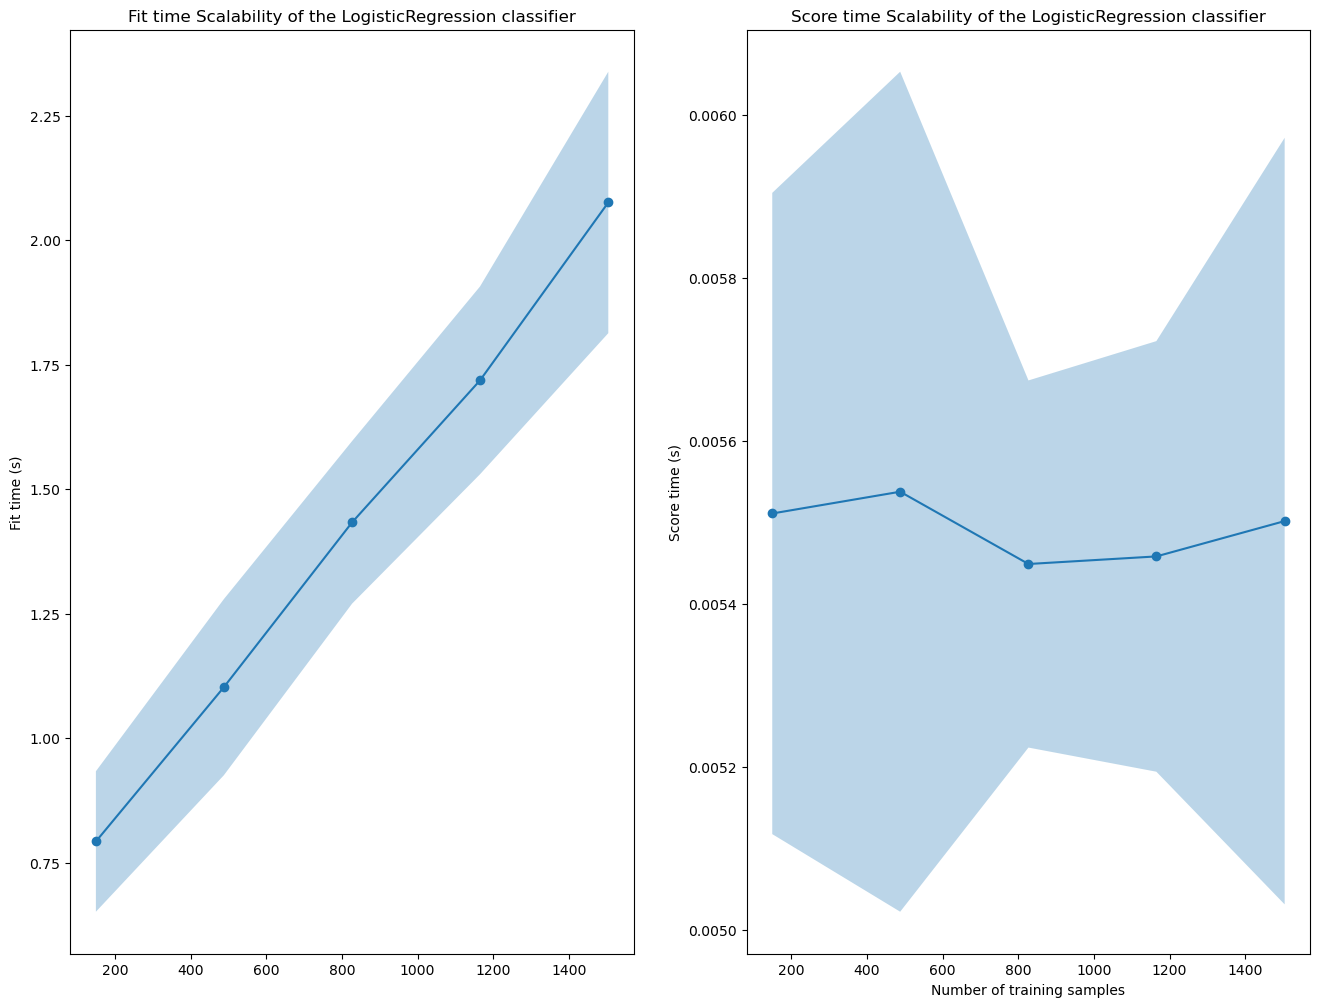

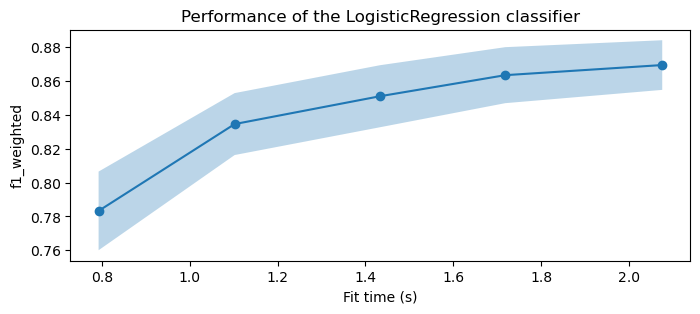

(array([[0.81916213, 0.90495062, 0.81716681, 0.80019522, 0.80132294,
         0.75352669, 0.57228565, 0.68771243, 0.56765103, 1.13079882,
         0.89313698, 0.85224533, 0.95738626, 0.71694922, 0.88302851,
         1.04422164, 1.04820132, 0.63108826, 0.70683813, 0.90109062,
         0.72263122, 0.85033083, 0.90529442, 0.6444931 , 1.04671216,
         1.04582739, 0.81798744, 0.6646471 , 0.72480512, 0.74023986,
         0.48880291, 0.54241896, 0.74951577, 0.83515549, 0.72022557,
         0.8112402 , 0.79277849, 0.6630764 , 0.70157361, 0.70735097,
         0.83374643, 0.8500731 , 0.59637976, 0.84597445, 1.01881289,
         0.76420093, 0.69807696, 0.8338685 , 0.87338567, 0.65941453],
        [1.12537718, 1.13537717, 1.58583117, 0.84930491, 1.15676117,
         1.56438088, 0.98509145, 1.08423257, 0.9800601 , 1.40797687,
         0.96043181, 1.0443244 , 1.09894419, 1.01600432, 0.87193322,
         1.30355549, 0.97919512, 0.84610701, 1.02553153, 1.20062947,
         1.17753363, 1.18840694, 

In [36]:
model_helpers.draw_scalability_curves(x_train_sampled, y_train_sampled, LogisticRegression(max_iter=1000000), n_jobs=4, cv_n_splits=50)

##### adaboost: 


- hyperparams tunning:
    - Exhaustive Grid Search

In [60]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}


# run grid search
grid_search = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4)), param_grid=param_grid, scoring='f1_weighted', n_jobs=4)
start = time()
grid_search.fit(x_train_sampled, y_train_sampled)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)


GridSearchCV took 14.35 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.989 (std: 0.004)
Parameters: {'learning_rate': 1.0, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.989 (std: 0.003)
Parameters: {'learning_rate': 1.0, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.986 (std: 0.008)
Parameters: {'learning_rate': 0.5, 'n_estimators': 100}



In [63]:
# Create a base classifier
base_classifier = DecisionTreeClassifier(max_depth=4)
# Create an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100,learning_rate=1.0, random_state=42)
print("adaboost classifier results:\n")
adaboost_classifier, doc = helpers.test_model(adaboost_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

adaboost classifier results:

     out of sample ( predict(test) ):
         accuracy: 97.52252252252252
         weighted F1 score: 97.53880598178844

     in sample ( predict(train) ):
         accuracy: 99.94680851063829
         weighted F1 score: 99.94680845043963


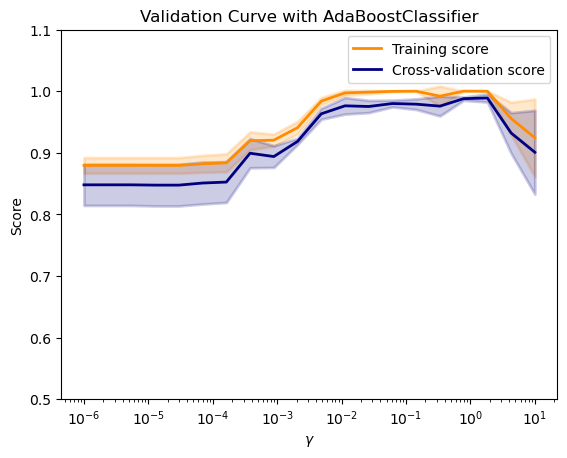

In [5]:
# Create a base classifier
base_classifier = DecisionTreeClassifier(max_depth=4)
# Create an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100, random_state=42)

param_range=np.logspace(-6,1, 20)
#param_range=np.linspace(-7,20,10)
test_scores_mean, train_scores_mean = model_helpers.draw_validation_curve(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          adaboost_classifier,
                                                                          n_jobs=5,
                                                                          param_range=param_range,
                                                                          param_name='learning_rate',
                                                                          y_lim= 0.5)


In [7]:
best_param_index = np.argmax(test_scores_mean)
best_param_value = param_range[best_param_index]
print("Best lr Parameter:", best_param_value)
print("Best Mean Test Score:", test_scores_mean[best_param_index],'         ',train_scores_mean[best_param_index])


Best lr Parameter: 1.8329807108324339
Best Mean Test Score: 0.9888404920713022           0.9998670210414445


In [5]:
# Create a base classifier
base_classifier = DecisionTreeClassifier(max_depth=4)
# Create an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100, random_state=42, learning_rate=1.8329807108324339)
print("adaboost classifier results:\n")
adaboost_classifier, doc = helpers.test_model(adaboost_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

adaboost classifier results:

     out of sample ( predict(test) ):
         accuracy: 96.84684684684684
         weighted F1 score: 96.84343295756341

     in sample ( predict(train) ):
         accuracy: 100.0
         weighted F1 score: 100.0


- learning curve

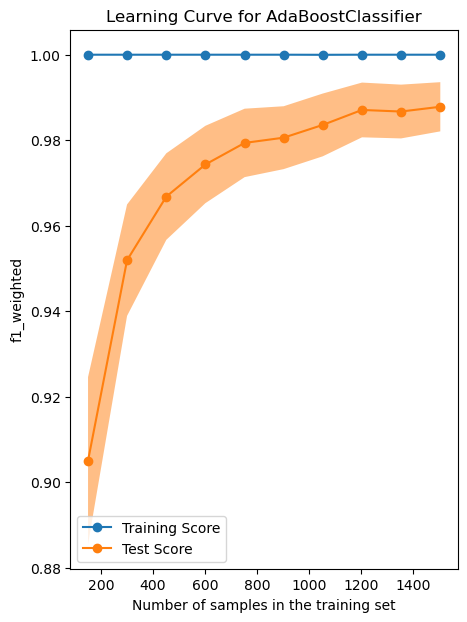

In [10]:
base_classifier = DecisionTreeClassifier(max_depth=4)
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100, random_state=42, learning_rate=1.8329807108324339)

model_helpers.draw_learning_curve(x_train_sampled, y_train_sampled, adaboost_classifier, n_jobs=5, cv_n_splits=50)

- scalabillity curve

[[0.04106879 0.04081202 0.04206562 0.03658009 0.05476761 0.03812122
  0.03760505 0.03670049 0.03817749 0.03777885 0.03728962 0.03674936
  0.0373342  0.03642488 0.03673887 0.03644228 0.03652263 0.03680801
  0.03642654 0.03656101 0.03666067 0.0367167  0.03727984 0.03711033
  0.03681827 0.03734517 0.03653026 0.03777313 0.03748012 0.03666186
  0.03803492 0.0365684  0.03642225 0.03771663 0.03590417 0.03655982
  0.0374465  0.03790879 0.03658414 0.03725433 0.03699946 0.03780556
  0.03717685 0.03705478 0.03741574 0.03759432 0.03664351 0.03736305
  0.03744817 0.03682613]
 [0.04012966 0.04368997 0.0428679  0.03810596 0.03781104 0.03776145
  0.03813267 0.03841829 0.03834438 0.03700495 0.03855157 0.03740716
  0.03683972 0.03731465 0.03666902 0.03679657 0.03714085 0.03646111
  0.0367682  0.03728795 0.03656316 0.03836942 0.03673768 0.03667355
  0.03748488 0.03715253 0.03584242 0.03684783 0.03679919 0.03753591
  0.03740525 0.03790116 0.03663087 0.03566051 0.03683305 0.03599358
  0.03724074 0.03697801

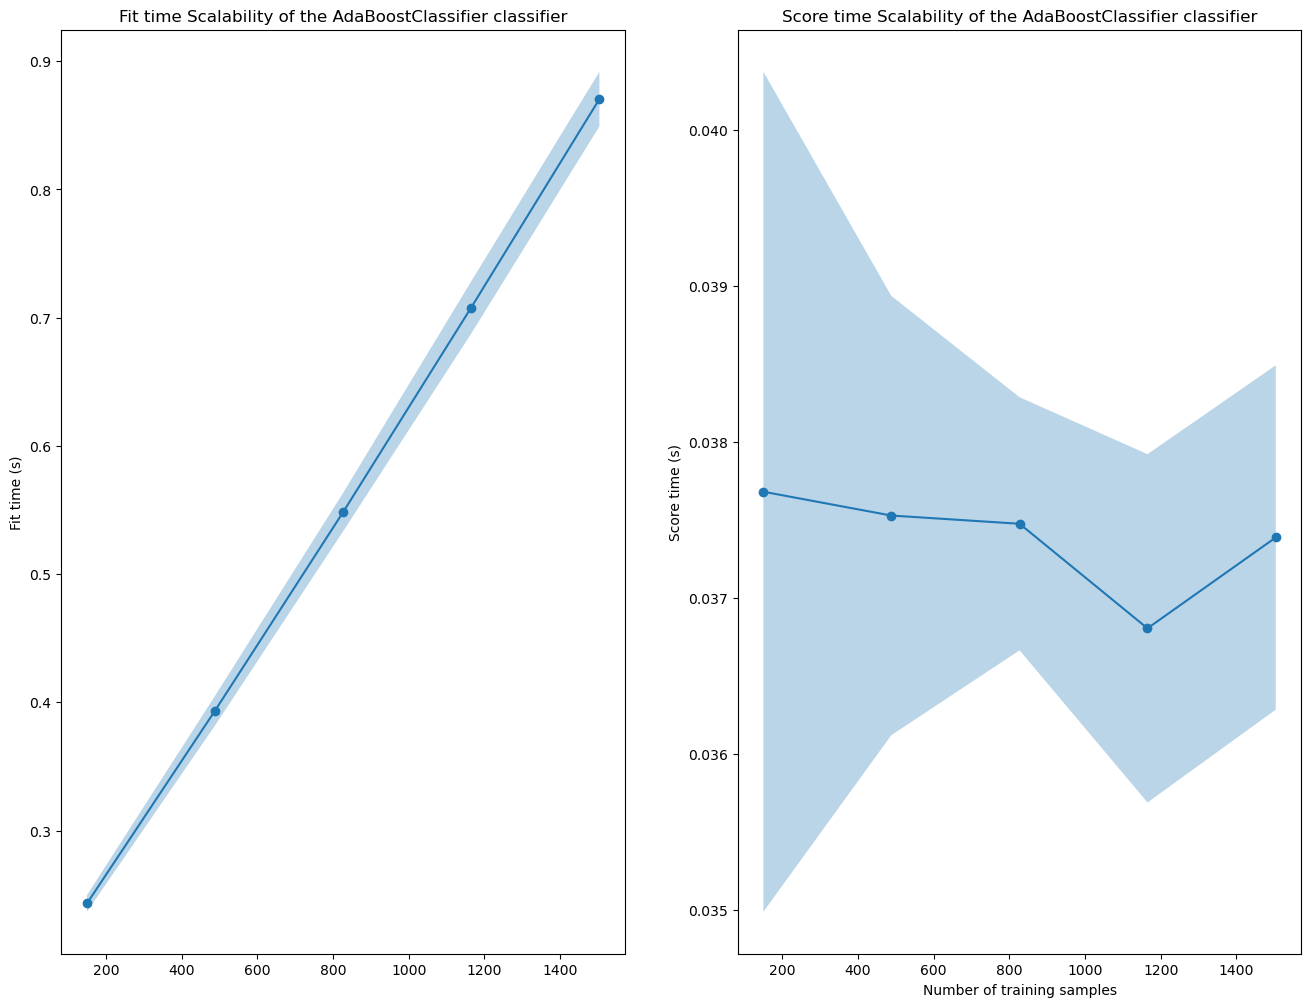

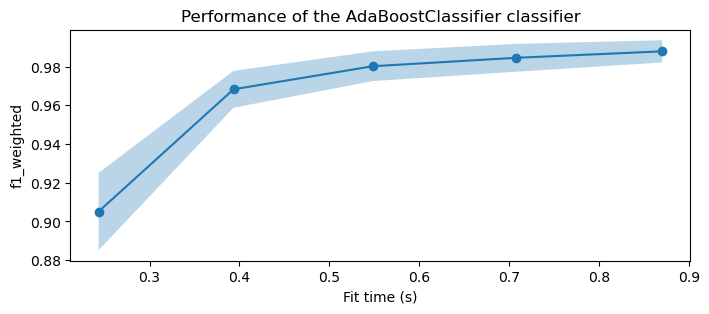

(array([[0.26877594, 0.26290655, 0.26226616, 0.24495912, 0.24767184,
         0.23765588, 0.24351478, 0.24595165, 0.24134302, 0.23896885,
         0.24342823, 0.23924065, 0.24321318, 0.23772287, 0.23813963,
         0.23504543, 0.23803806, 0.23750854, 0.23938751, 0.23878884,
         0.23809505, 0.23969674, 0.2394104 , 0.24134326, 0.23894668,
         0.24730515, 0.23752403, 0.24158812, 0.24640417, 0.23758745,
         0.24146199, 0.23894119, 0.2430954 , 0.24184155, 0.23575258,
         0.2477448 , 0.24640512, 0.24728107, 0.24446654, 0.24624753,
         0.24021292, 0.24662614, 0.24260354, 0.24257398, 0.24854851,
         0.24471664, 0.23942542, 0.2457087 , 0.23860264, 0.24624515],
        [0.42658472, 0.43743944, 0.42250657, 0.39659715, 0.42803693,
         0.39755392, 0.39270306, 0.39462638, 0.3949244 , 0.38757253,
         0.39203262, 0.39536953, 0.3819232 , 0.39300776, 0.38416862,
         0.38483453, 0.38956356, 0.38199925, 0.38456416, 0.3944006 ,
         0.38343406, 0.39724469, 

In [12]:
base_classifier = DecisionTreeClassifier(max_depth=4)
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100, random_state=42, learning_rate=1.8329807108324339)

model_helpers.draw_scalability_curves(x_train_sampled, y_train_sampled, adaboost_classifier, n_jobs=4, cv_n_splits=50)

##### SVM.

- hyperparams tunning:
    - Exhaustive Grid Search

In [5]:
# # specify parameters and distributions to sample from
# from sklearn.utils.fixes import loguniform
# param_dist = {  'C': loguniform(1e0, 1e3),
#                 'gamma': loguniform(1e-4, 1e-3),
#                 'kernel': [ 'linear']
#                 }

# # run randomized search
# n_iter_search = 15
# random_search = RandomizedSearchCV(
#     SVC(), param_distributions=param_dist, n_iter=n_iter_search
# )

# start = time()
# random_search.fit(x_train_sampled, y_train_sampled)
# print(
#     "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
#     % ((time() - start), n_iter_search)
# )
# report(random_search.cv_results_)

In [7]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


# run grid search
grid_search = GridSearchCV(SVC(), param_grid=param_grid, scoring='f1_weighted')
start = time()
grid_search.fit(x_train_sampled, y_train_sampled)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.989 (std: 0.006)
Parameters: {'C': 1000, 'kernel': 'linear'}

Model with rank: 2
Mean validation score: 0.987 (std: 0.004)
Parameters: {'C': 100, 'kernel': 'linear'}

Model with rank: 3
Mean validation score: 0.982 (std: 0.009)
Parameters: {'C': 10, 'kernel': 'linear'}



- graphing different values for the solver parameters :

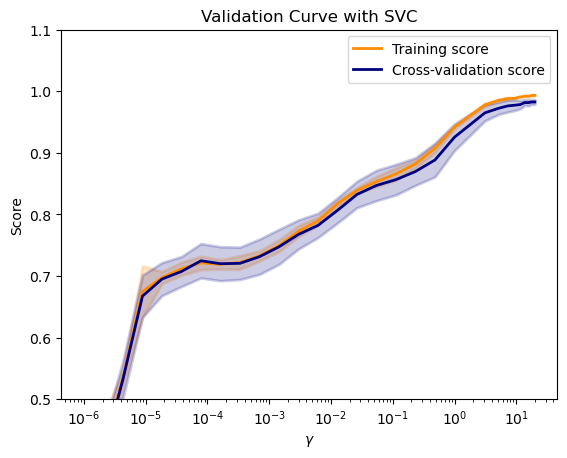

In [36]:
param_range_1=np.logspace(-6,0, 20)
param_range=np.linspace(1,20,10)
test_scores_mean, train_scores_mean = model_helpers.draw_validation_curve(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          SVC(kernel='linear'),
                                                                          n_jobs=5,
                                                                          param_range=np.append(param_range_1, param_range),
                                                                          param_name='C',
                                                                          y_lim= 0.5,
                                                                          cv=4)

In [8]:
# Create svm classifier
svm_classifier = SVC(kernel='linear', C=1000) #random_state=42
print("svm classifier results:\n")
svm_classifier, doc = helpers.test_model(svm_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

svm classifier results:

     out of sample ( predict(test) ):
         accuracy: 97.97297297297297
         weighted F1 score: 97.95332569443508

     in sample ( predict(train) ):
         accuracy: 99.8936170212766
         weighted F1 score: 99.89361653968555


- learning curve

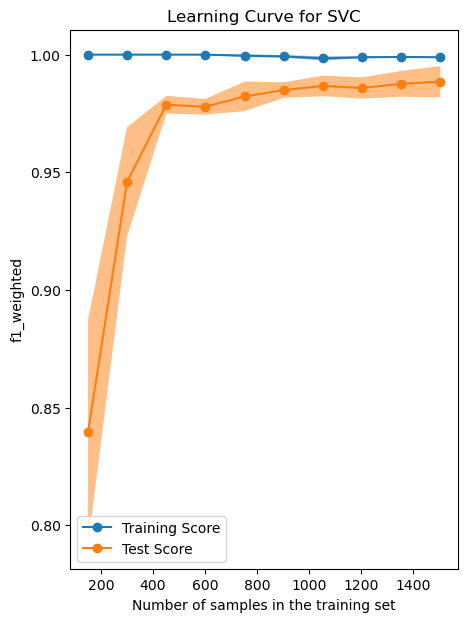

In [15]:
model_helpers.draw_learning_curve(x_train_sampled, y_train_sampled, SVC(kernel='linear', C=1000), n_jobs=10, cv_n_splits=3)

- scalability curve

[[0.007406   0.00642824 0.00682712 0.01101494]
 [0.007339   0.00898051 0.00785995 0.00653172]
 [0.00736427 0.0072372  0.00674653 0.00660396]
 [0.0071826  0.00690675 0.00676179 0.00755334]
 [0.00712371 0.00741029 0.00675368 0.00646114]]


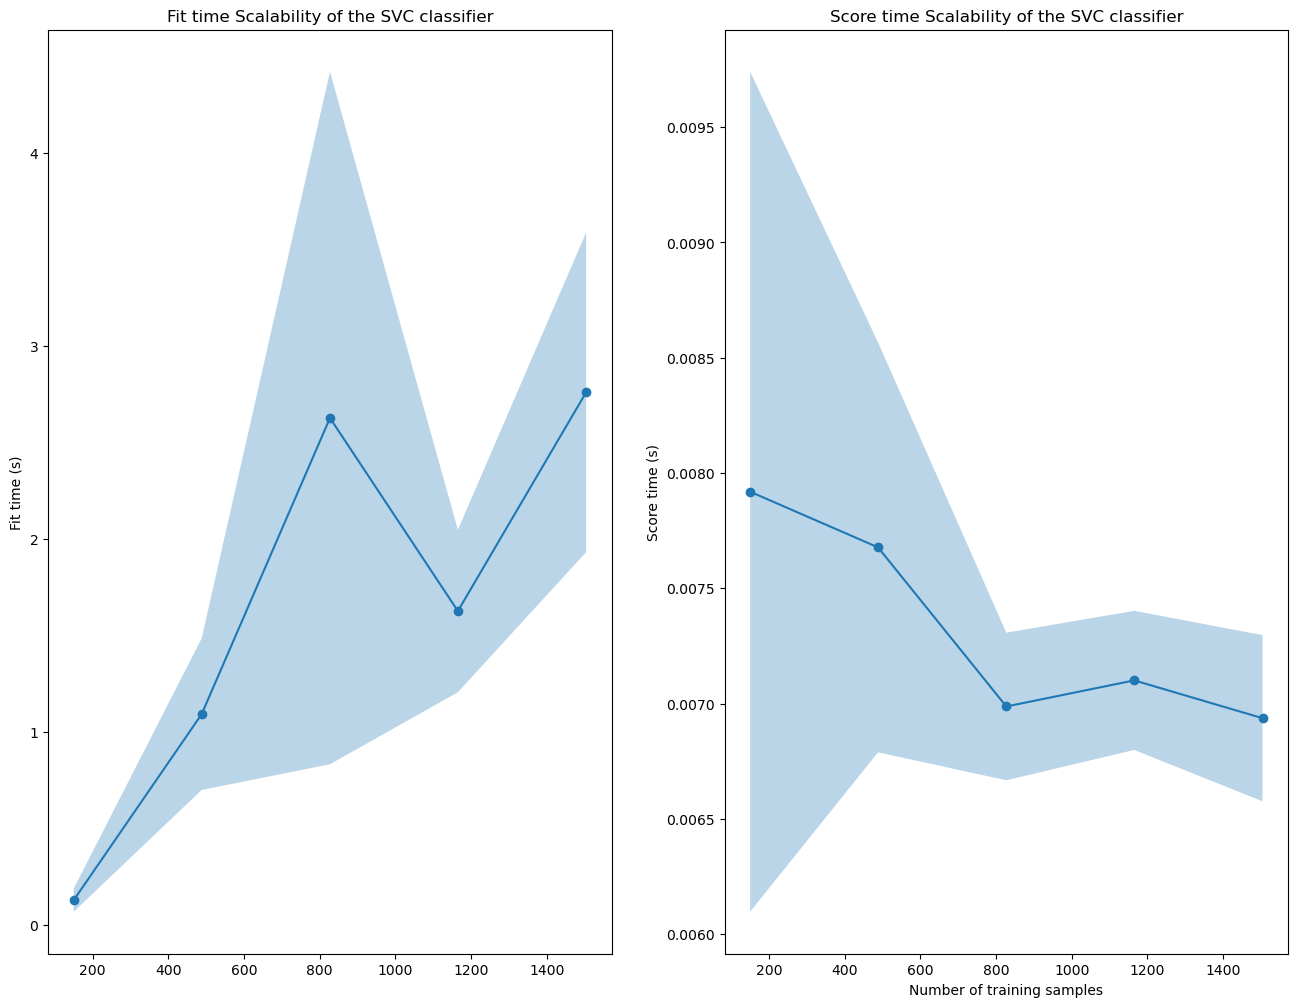

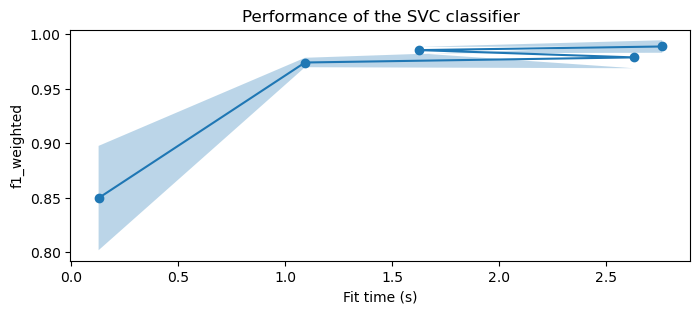

In [34]:
test_scores_mean, train_scores_mean = model_helpers.draw_scalability_curves(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          SVC(kernel='linear', C=1000),
                                                                          n_jobs=4,
                                                                          cv_n_splits=4)

##### random forrest:

- hyper parameters tunning:

In [40]:
param_grid = [
{
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}
 ]


# run grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1_weighted', n_jobs=4)
start = time()
grid_search.fit(x_train_sampled, y_train_sampled)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

GridSearchCV took 276.67 seconds for 81 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.977 (std: 0.011)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.976 (std: 0.013)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.975 (std: 0.015)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}



In [46]:
# Create random forrest classifier
randomforrest_classifier = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
print("random forrest classifier results:\n")
randomforrest_classifier, doc = helpers.test_model(randomforrest_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

random forrest classifier results:

     out of sample ( predict(test) ):
         accuracy: 97.07207207207207
         weighted F1 score: 97.10686209143051

     in sample ( predict(train) ):
         accuracy: 100.0
         weighted F1 score: 100.0


- learning curve

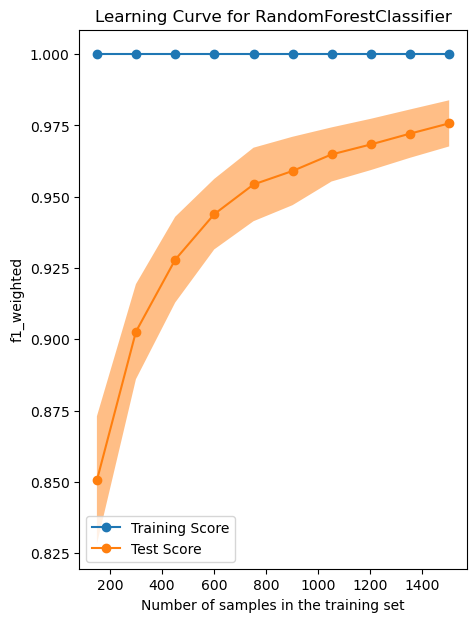

In [50]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
model_helpers.draw_learning_curve(x_train_sampled, y_train_sampled, clf, n_jobs=10, cv_n_splits=50)

- scalability curve

[[0.06493998 0.05704331 0.06046104 0.05973577 0.06139374 0.05898666
  0.05861425 0.06028128 0.05671883 0.05996656 0.05799222 0.07316589
  0.0587914  0.05832696 0.05883002 0.05864477 0.06048417 0.05855846
  0.05838013 0.06093073 0.05920601 0.05865264 0.05884385 0.06060719
  0.06004167 0.05768943 0.05890298 0.06157446 0.05995703 0.05926847
  0.06007433 0.05869579 0.05884361 0.05963135 0.0592854  0.06397557
  0.06231523 0.05993891 0.05860543 0.05804777 0.06234717 0.06439519
  0.06020927 0.06164932 0.06075668 0.05953288 0.07710791 0.05908537
  0.06090593 0.06001711]
 [0.06583548 0.0628829  0.06069636 0.0618968  0.06241417 0.06066394
  0.06237125 0.05901861 0.06136298 0.06110501 0.05994105 0.06026697
  0.06117487 0.05960155 0.06190467 0.06176972 0.05884552 0.06106496
  0.06225538 0.06137848 0.06040621 0.06288552 0.0617702  0.05917025
  0.06202865 0.0624516  0.06234646 0.05933857 0.06195784 0.06206965
  0.06109595 0.0611012  0.06450915 0.06279373 0.06259727 0.06396627
  0.09849358 0.06233072

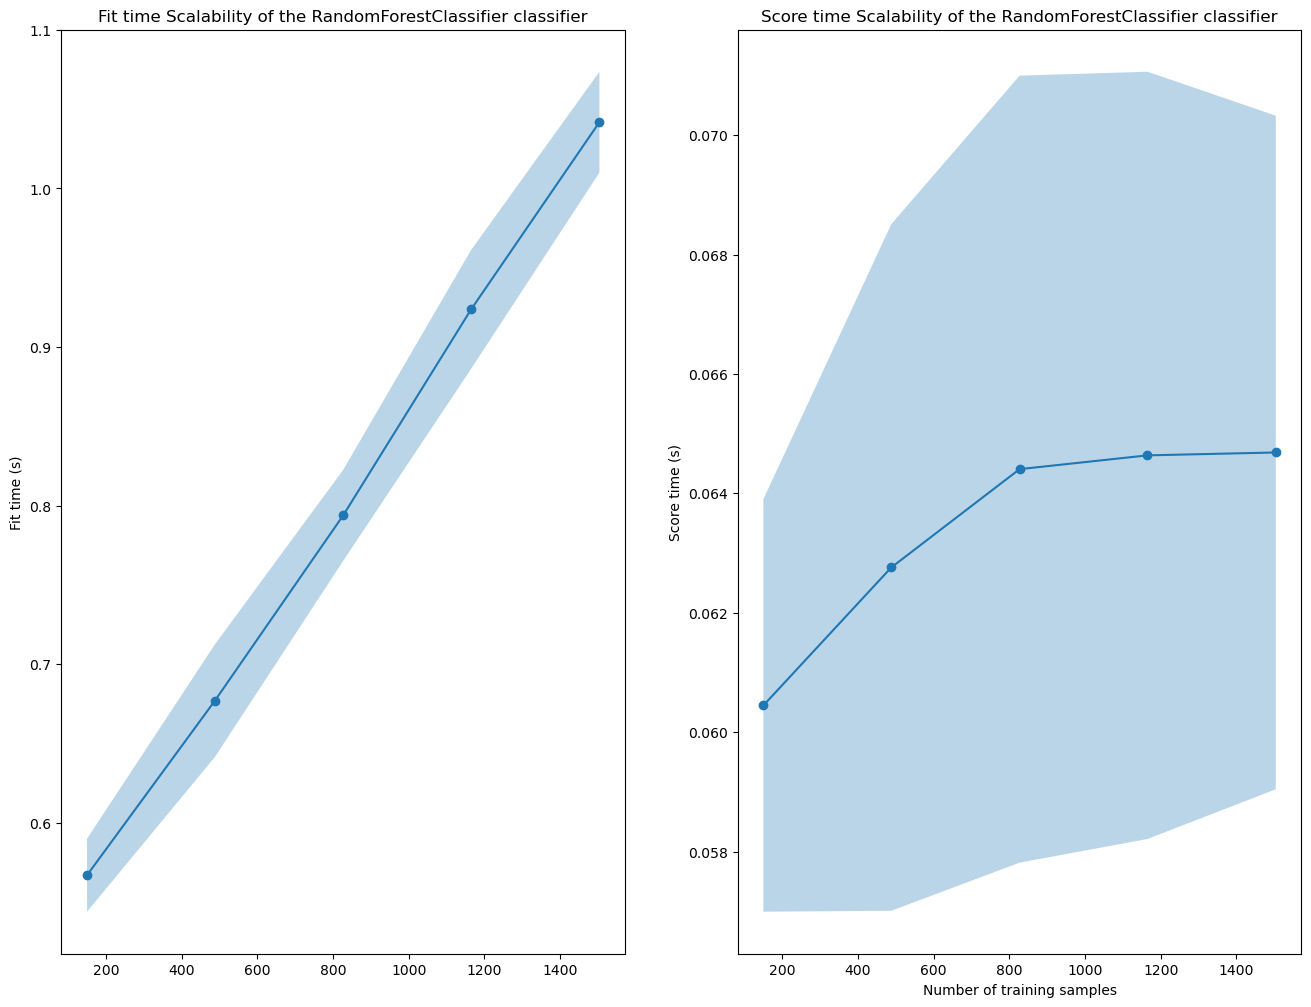

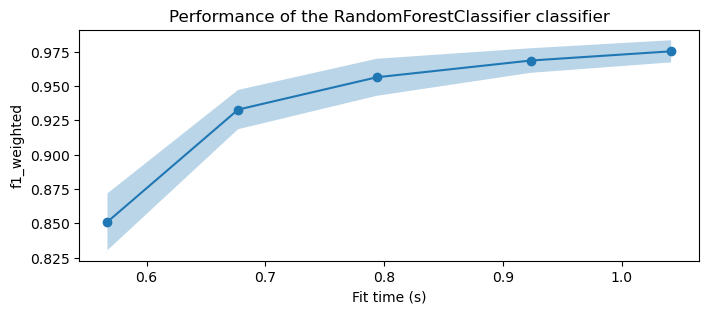

In [52]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)

test_scores_mean, train_scores_mean = model_helpers.draw_scalability_curves(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          clf,
                                                                          n_jobs=4,
                                                                          cv_n_splits=50)

# Final Comparison:










In [64]:
# Create a logistic regression classifier
logisticregression_classifier = LogisticRegression(max_iter=1000000, C=1000)
print("logistic regression classifier results:\n")
logisticregression_classifier, doc = helpers.test_model(logisticregression_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

logistic regression classifier results:

     out of sample ( predict(test) ):
         accuracy: 96.62162162162163
         weighted F1 score: 96.56955903271692

     in sample ( predict(train) ):
         accuracy: 99.7340425531915
         weighted F1 score: 99.73404134728855


In [65]:
# Create a base classifier
base_classifier = DecisionTreeClassifier(max_depth=4)
# Create an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=100,learning_rate=1.0, random_state=42)
print("adaboost classifier results:\n")
adaboost_classifier, doc = helpers.test_model(adaboost_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

adaboost classifier results:

     out of sample ( predict(test) ):
         accuracy: 97.52252252252252
         weighted F1 score: 97.53880598178844

     in sample ( predict(train) ):
         accuracy: 99.94680851063829
         weighted F1 score: 99.94680845043963


In [66]:
# Create svm classifier
svm_classifier = SVC(kernel='linear', C=1000) #random_state=42
print("svm classifier results:\n")
svm_classifier, doc = helpers.test_model(svm_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

svm classifier results:

     out of sample ( predict(test) ):
         accuracy: 97.97297297297297
         weighted F1 score: 97.95332569443508

     in sample ( predict(train) ):
         accuracy: 99.8936170212766
         weighted F1 score: 99.89361653968555


In [67]:
# Create random forrest classifier
randomforrest_classifier = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
print("random forrest classifier results:\n")
randomforrest_classifier, doc = helpers.test_model(randomforrest_classifier, x_train_sampled, y_train_sampled, x_test, y_test)

random forrest classifier results:

     out of sample ( predict(test) ):
         accuracy: 96.3963963963964
         weighted F1 score: 96.43755861573422

     in sample ( predict(train) ):
         accuracy: 100.0
         weighted F1 score: 100.0


##### save the best model:
    1. svm
    2. adaboost
    3. logistic regression
    4.random forrest

In [69]:
# Save the classifier using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)